In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'].split(',')

['0']

In [2]:
DEVICE = 'cuda:0'

In [3]:
import matplotlib.pyplot as plt
import numpy as np

In [4]:
import numpy as np
import torch
from typing import Optional
from scipy.optimize import linear_sum_assignment


def cluster_accuracy(y_true, y_predicted, cluster_number: Optional[int] = None):
    """
    Calculate clustering accuracy after using the linear_sum_assignment function in SciPy to
    determine reassignments.
    :param y_true: list of true cluster numbers, an integer array 0-indexed
    :param y_predicted: list  of predicted cluster numbers, an integer array 0-indexed
    :param cluster_number: number of clusters, if None then calculated from input
    :return: reassignment dictionary, clustering accuracy
    """
    if cluster_number is None:
        cluster_number = (
            max(y_predicted.max(), y_true.max()) + 1
        )  # assume labels are 0-indexed
    count_matrix = np.zeros((cluster_number, cluster_number), dtype=np.int64)
    for i in range(y_predicted.size):
        count_matrix[y_predicted[i], y_true[i]] += 1

    row_ind, col_ind = linear_sum_assignment(count_matrix.max() - count_matrix)
    reassignment = dict(zip(row_ind, col_ind))
    accuracy = count_matrix[row_ind, col_ind].sum() / y_predicted.size
    return reassignment, accuracy

In [5]:
def lp_distance(X, Y, p=1):
    """
    Computes row wise minkowski distances between matrices X and Y
    """
    return torch.sum(torch.abs(X-Y)**p, dim=1)**(1/p)

In [6]:
from transformers import PreTrainedTokenizer
from typing import *

def mask_tokens(inputs: torch.Tensor, tokenizer) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Prepare masked tokens inputs/labels for masked language modeling: 80% MASK, 10% random, 10% original.
    """

    if tokenizer.mask_token is None:
        raise ValueError(
            "This tokenizer does not have a mask token which is necessary for masked language modeling. Remove the --mlm flag if you want to use this tokenizer."
        )

    labels = inputs.clone()
    # We sample a few tokens in each sequence for masked-LM training (with probability args.mlm_probability defaults to 0.15 in Bert/RoBERTa)
    probability_matrix = torch.full(labels.shape, 0.15)
    special_tokens_mask = [
        tokenizer.get_special_tokens_mask(val, already_has_special_tokens=True) for val in labels.tolist()
    ]
    probability_matrix.masked_fill_(torch.tensor(special_tokens_mask, dtype=torch.bool), value=0.0)
    if tokenizer._pad_token is not None:
        padding_mask = labels.eq(tokenizer.pad_token_id)
        probability_matrix.masked_fill_(padding_mask, value=0.0)
    masked_indices = torch.bernoulli(probability_matrix).bool()
    labels[~masked_indices] = -100  # We only compute loss on masked tokens

    # 80% of the time, we replace masked input tokens with tokenizer.mask_token ([MASK])
    indices_replaced = torch.bernoulli(torch.full(labels.shape, 0.8)).bool() & masked_indices
    inputs[indices_replaced] = tokenizer.convert_tokens_to_ids(tokenizer.mask_token)

    # 10% of the time, we replace masked input tokens with random word
    indices_random = torch.bernoulli(torch.full(labels.shape, 0.5)).bool() & masked_indices & ~indices_replaced
    random_words = torch.randint(len(tokenizer), labels.shape, dtype=torch.long)
    inputs[indices_random] = random_words[indices_random]

    # The rest of the time (10% of the time) we keep the masked input tokens unchanged
    return inputs, labels

In [7]:
from torch.utils.data import Dataset, DataLoader


class TextDataset(Dataset):
    def __init__(self, texts, labels):
        
        self.texts = texts
        self.labels = labels


        self.labels = torch.tensor(self.labels, dtype=torch.float)
        
    def __getitem__(self, index):
        return self.texts[index], self.labels[index]

    
    def __len__(self):
        return len(self.texts)

In [8]:
# 20 newsgroups
from sklearn.datasets import fetch_20newsgroups
data = fetch_20newsgroups(
    categories=['comp.graphics', 'talk.religion.misc', 'rec.autos', 'misc.forsale'],
    remove=('headers', 'footers', 'quotes'),
    shuffle=True,
    random_state=42
)
texts, labels = data.data, data.target

<BarContainer object of 4 artists>

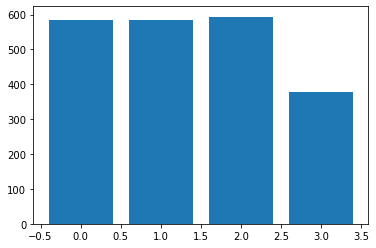

In [9]:
plt.bar(*np.unique(labels, return_counts=True))

In [10]:
import tensorflow_datasets as tfds
from itertools import chain

train_ds = tfds.load('ag_news_subset', split='train', shuffle_files=True)
test_ds = tfds.load('ag_news_subset', split='test', shuffle_files=True)

texts, labels = [], []

for ds in (train_ds, test_ds):
    for example in tfds.as_numpy(ds):
        text, label = example['description'], example['label']
        texts.append(text.decode("utf-8"))
        labels.append(label)

labels = np.array(labels)

del train_ds
del test_ds

INFO:absl:Load dataset info from /home/keller/tensorflow_datasets/ag_news_subset/1.0.0
INFO:absl:Reusing dataset ag_news_subset (/home/keller/tensorflow_datasets/ag_news_subset/1.0.0)
INFO:absl:Constructing tf.data.Dataset for split train, from /home/keller/tensorflow_datasets/ag_news_subset/1.0.0
INFO:absl:Load dataset info from /home/keller/tensorflow_datasets/ag_news_subset/1.0.0
INFO:absl:Reusing dataset ag_news_subset (/home/keller/tensorflow_datasets/ag_news_subset/1.0.0)
INFO:absl:Constructing tf.data.Dataset for split test, from /home/keller/tensorflow_datasets/ag_news_subset/1.0.0


In [11]:
from sklearn.model_selection import train_test_split

texts, _, labels, _ = train_test_split(texts, labels, test_size=0.995, random_state=42)
len(texts), len(labels)

(638, 638)

In [12]:
labels

array([1, 3, 1, 2, 0, 3, 3, 2, 0, 1, 1, 0, 0, 2, 1, 2, 3, 1, 0, 1, 3, 1,
       0, 2, 1, 2, 3, 1, 2, 0, 0, 2, 1, 2, 2, 3, 3, 0, 1, 1, 2, 3, 0, 3,
       0, 0, 3, 3, 1, 3, 0, 3, 3, 1, 0, 2, 2, 3, 0, 3, 3, 3, 2, 1, 2, 3,
       3, 1, 0, 2, 2, 2, 1, 0, 3, 0, 0, 0, 0, 1, 0, 3, 1, 1, 3, 3, 3, 2,
       0, 0, 0, 1, 2, 0, 0, 1, 0, 3, 1, 1, 2, 2, 3, 1, 0, 0, 0, 1, 1, 3,
       2, 1, 0, 1, 1, 3, 0, 3, 2, 3, 1, 1, 3, 1, 3, 0, 2, 3, 0, 0, 2, 0,
       0, 2, 3, 3, 3, 3, 0, 2, 3, 0, 2, 2, 1, 3, 2, 2, 0, 0, 2, 1, 3, 0,
       1, 0, 0, 3, 3, 2, 2, 1, 1, 1, 3, 2, 3, 3, 3, 2, 2, 2, 3, 2, 1, 1,
       2, 2, 2, 3, 3, 0, 1, 3, 2, 2, 0, 3, 2, 3, 3, 0, 2, 3, 1, 2, 0, 0,
       0, 3, 3, 2, 3, 1, 2, 1, 2, 1, 3, 1, 3, 0, 3, 2, 1, 2, 3, 3, 0, 1,
       0, 2, 3, 3, 1, 1, 0, 2, 1, 0, 0, 1, 0, 3, 3, 3, 2, 3, 3, 2, 3, 0,
       2, 2, 3, 1, 3, 0, 2, 0, 2, 1, 1, 1, 3, 0, 0, 0, 3, 2, 2, 3, 0, 2,
       1, 0, 0, 0, 2, 2, 1, 0, 1, 3, 3, 1, 1, 2, 2, 0, 1, 3, 0, 1, 3, 2,
       1, 1, 0, 2, 1, 0, 3, 3, 3, 1, 0, 1, 2, 0, 0,

In [13]:
data = TextDataset(texts, labels)
data_loader = DataLoader(dataset=data, batch_size=4, shuffle=False)

In [14]:
from transformers import DistilBertTokenizer, DistilBertForMaskedLM
from transformers import ElectraTokenizer, ElectraForMaskedLM
from transformers import AutoTokenizer, AutoModelForMaskedLM
from transformers import BertTokenizer, BertForMaskedLM
from transformers import RobertaTokenizer, RobertaForMaskedLM

import torch

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased', return_dict=True)
lm_model = DistilBertForMaskedLM.from_pretrained('distilbert-base-uncased', return_dict=True)

#tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', return_dict=True)
#lm_model = BertForMaskedLM.from_pretrained('bert-base-uncased', return_dict=True)

#tokenizer = RobertaTokenizer.from_pretrained('roberta-base', return_dict=True)
#lm_model = RobertaForMaskedLM.from_pretrained('roberta-base', return_dict=True)

#tokenizer = ElectraTokenizer.from_pretrained('google/electra-base-discriminator', return_dict=True)
#lm_model = ElectraForMaskedLM.from_pretrained('google/electra-base-discriminator', return_dict=True)

#tokenizer = AutoTokenizer.from_pretrained("distilroberta-base", return_dict=True)
#lm_model = AutoModelForMaskedLM.from_pretrained("distilroberta-base", return_dict=True)


lm_model.to(DEVICE)

DistilBertForMaskedLM(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): L

In [15]:
from tqdm import tqdm
embeddings = []
for index, text in tqdm(enumerate(texts)):
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True)
    inputs = inputs.to(DEVICE)
    outputs = lm_model.base_model(**inputs)
    cls_embedding = outputs.last_hidden_state[:,0,:].flatten().cpu().detach().numpy()
    
    embeddings.append(cls_embedding)

embeddings = np.array(embeddings)

638it [00:05, 119.54it/s]


In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score, silhouette_score


tfidf = TfidfVectorizer(max_features=1000, stop_words='english')
Xtfidf = tfidf.fit_transform(texts)

kmeans = KMeans(n_clusters=np.unique(labels).shape[0], n_init=20)
kmeans_cluster_tfidf = kmeans.fit_predict(Xtfidf)


print(cluster_accuracy(labels, kmeans_cluster_tfidf)[1])
print(normalized_mutual_info_score(labels, kmeans_cluster_tfidf))
print(adjusted_rand_score(labels, kmeans_cluster_tfidf))
print(silhouette_score(Xtfidf, kmeans_cluster_tfidf, metric="cosine"))

0.3730407523510972
0.07481401001322913
0.05463561299185846
0.011396406313477311


In [17]:
#from sklearn.cluster import KMeans
#from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score, silhouette_score
#from sentence_transformers import SentenceTransformer
#
#sbert_model = SentenceTransformer('distilbert-base-nli-mean-tokens')
#
#sbert_embeddings = sbert_model.encode(texts)
#
#kmeans = KMeans(n_clusters=np.unique(labels).shape[0], n_init=20)
#kmeans_cluster_sbert = kmeans.fit_predict(sbert_embeddings)
#
#print(cluster_accuracy(labels, kmeans_cluster_sbert)[1])
#print(normalized_mutual_info_score(labels, kmeans_cluster_sbert))
#print(adjusted_rand_score(labels, kmeans_cluster_sbert))
#print(silhouette_score(sbert_embeddings, kmeans_cluster_sbert, metric="cosine"))

In [18]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=np.unique(labels).shape[0], n_init=20)

kmeans_cluster = kmeans.fit_predict(embeddings)
kmean_centroids = torch.from_numpy(kmeans.cluster_centers_)
kmean_centroids = kmean_centroids.to(DEVICE)

In [19]:
from umap import UMAP

umap = UMAP(n_components=2)
embeddings_plot = umap.fit_transform(embeddings)

/home/keller/.conda/envs/cuda/lib/python3.8/site-packages/numba/np/ufunc/parallel.py:355: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 10006. The TBB threading layer is disabled.
  warnings.warn(problem)


In [20]:
import plotly.express as px
fig = px.scatter(x=embeddings_plot[:, 0], y=embeddings_plot[:, 1], color=[f'{i}' for i in kmeans_cluster])
fig.show()

In [21]:
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score, silhouette_score

print(cluster_accuracy(labels, kmeans_cluster)[1])
print(normalized_mutual_info_score(labels, kmeans_cluster))
print(adjusted_rand_score(labels, kmeans_cluster))
print(silhouette_score(embeddings, kmeans_cluster, metric="cosine"))

0.5971786833855799
0.3992632807352365
0.3080741250002945
0.131854


In [22]:
#import random
#random.seed(42)
#initial_centroids = np.array([embeddings[i] for i in (random.randint(0, embeddings.shape[0]-1) for _ in range(np.unique(labels).shape[0]))])
#initial_centroids = torch.from_numpy(initial_centroids).to(DEVICE)
#initial_centroids

In [24]:
from sklearn.cluster.k_means_ import _k_init
from sklearn.utils.extmath import row_norms

# Using KMeans++ initialization
initial_centroids = _k_init(
    embeddings,
    #n_clusters=np.unique(labels).shape[0],
    n_clusters=20,
    x_squared_norms=row_norms(embeddings, squared=True),  #aka np.linalg.norm(embeddings, axis=1)**2
    random_state=np.random.RandomState(42))
initial_centroids = torch.from_numpy(initial_centroids).to(DEVICE)
initial_centroids

/home/keller/.conda/envs/cuda/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning:

The sklearn.cluster.k_means_ module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.cluster. Anything that cannot be imported from sklearn.cluster is now part of the private API.



tensor([[-0.2466, -0.2599,  0.1819,  ..., -0.2952,  0.5414,  0.3699],
        [-0.0698, -0.2036,  0.0556,  ...,  0.0086,  0.3377,  0.3447],
        [-0.0614, -0.2202, -0.0644,  ..., -0.1563,  0.2006,  0.1644],
        ...,
        [-0.4078, -0.3321,  0.0385,  ...,  0.0656,  0.3372,  0.4134],
        [-0.1895, -0.1446, -0.3310,  ..., -0.1729,  0.2881,  0.1322],
        [-0.1995, -0.1337,  0.0404,  ..., -0.0029,  0.3720,  0.4780]],
       device='cuda:0')

Epoch 0 (Alpha -0.0) | Batch: 159 | Combined Loss: 24.430267024064506 | Clustering Loss: 94.81513710031686 | LM Loss 0.7264827489852905 | Accuracy 1.0: : 160it [00:10, 15.12it/s]  


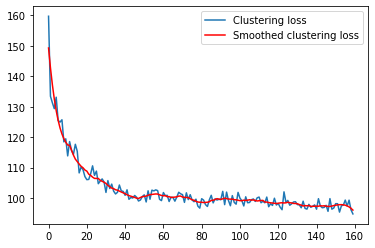

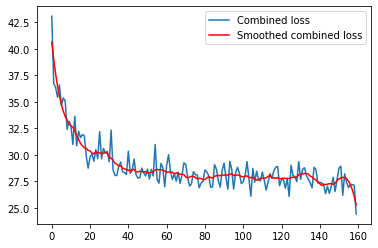

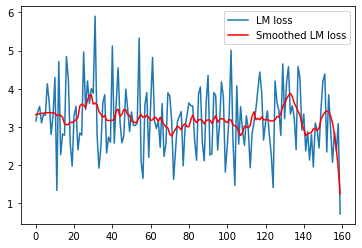

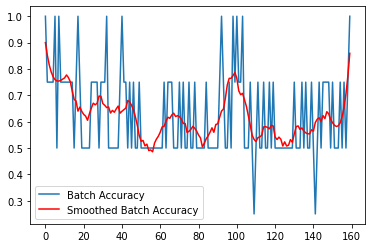

Epoch 1 (Alpha -1.5) | Batch: 159 | Combined Loss: 25.834532272520477 | Clustering Loss: 92.48048882366345 | LM Loss 2.7144100666046143 | Accuracy 0.5: : 160it [00:09, 16.41it/s] 


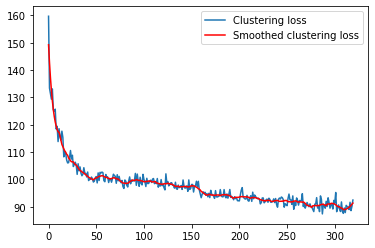

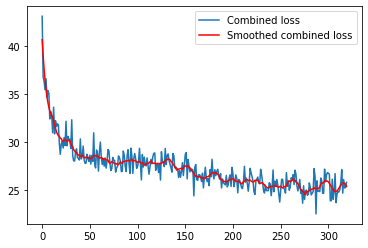

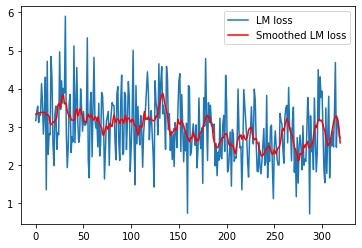

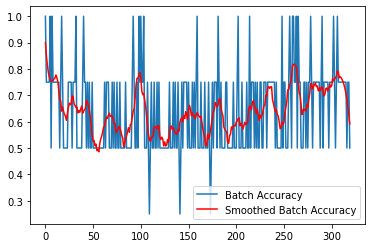

Epoch 2 (Alpha -3.0) | Batch: 159 | Combined Loss: 23.228151238877885 | Clustering Loss: 90.41908398039863 | LM Loss 0.6233802437782288 | Accuracy 1.0: : 160it [00:09, 16.43it/s] 


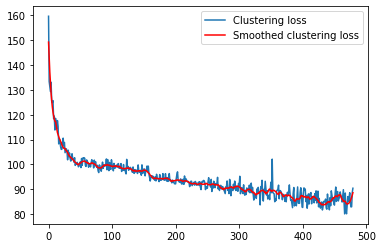

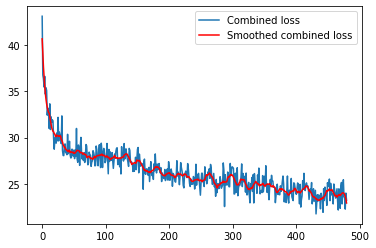

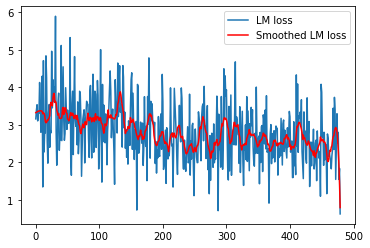

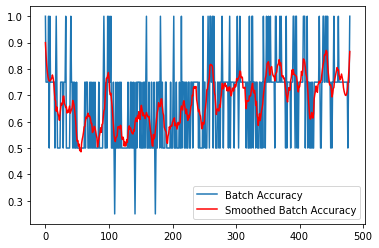

Epoch 3 (Alpha -6.0) | Batch: 159 | Combined Loss: 22.89698041795 | Clustering Loss: 86.85706477635323 | LM Loss 1.1827142238616943 | Accuracy 0.5: : 160it [00:09, 16.15it/s]     


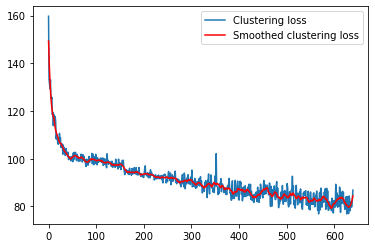

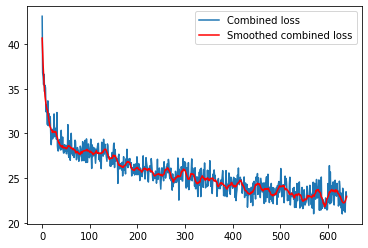

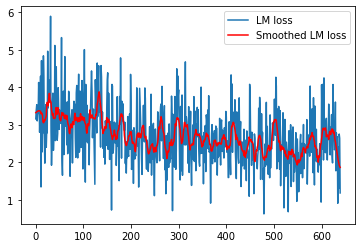

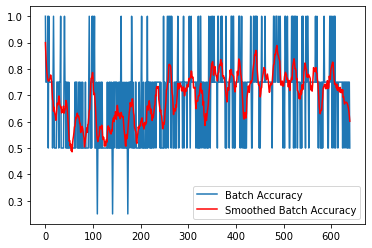

In [25]:
from scipy.signal import savgol_filter

centroids = initial_centroids.clone().to(DEVICE).requires_grad_(True)
#centroids = torch.Tensor(4, 768).uniform_(-10, 10).to(torch.float64).to(DEVICE).requires_grad_(True)
#centroids = kmean_centroids.clone().to(DEVICE).requires_grad_(True)  # go this way (cluster hardening)

opt = torch.optim.AdamW(
    params=[centroids] + list(lm_model.parameters()),
    lr=2e-5, #2e-5
    eps=1e-8
)



lm_model.train()

comb_losses = []
clustering_losses = []
lm_losses = []
c_hist = []
emb_hist = []
acc = []

n_epochs = 4
annealing_alpha = np.linspace(0.0, 2.5, n_epochs)
#annealing_alpha = [1.5] * n_epochs
annealing_alpha = [0.0, 1.5, 3.0, 6.0, 12.0]

for epoch, alpha in zip(range(n_epochs), annealing_alpha):
    
    predicted_labels = []
    true_labels = []
    embs = []
    t = [] # improve this asap!

    c_hist.append(centroids.clone().detach().cpu().numpy())
    pbar = tqdm(enumerate(data_loader))
    for batch, batch_data in pbar:
        # lm part 
        texts, batch_labels = batch_data
        inputs = tokenizer(
                    texts,
                    return_tensors='pt',
                    padding=True,
                    truncation=True)
        t.extend(texts)
        
        true_labels.extend(batch_labels)
        
        
        # clustering part
        input_ids = inputs['input_ids'].clone()
        input_ids, labels = mask_tokens(input_ids, tokenizer)
        inputs['input_ids'] = input_ids

        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        outputs = lm_model(labels=labels, **inputs)
        lm_loss = outputs.loss
        
        
        texts, batch_labels = batch_data
        inputs = tokenizer(
                    texts,
                    return_tensors='pt',
                    padding=True,
                    truncation=True)
        inputs.to(DEVICE)
        
        # 0. obtain embeddings for each input
        input_embeddings = lm_model.base_model(**inputs).last_hidden_state[:,0,:]
        input_embeddings = input_embeddings.to(torch.float64)
        
        embs.append(input_embeddings.clone().cpu().detach().numpy())

        distances = torch.stack([lp_distance(embedding.unsqueeze(0), centroids) for embedding in input_embeddings])
        #nearest_centroids = torch.argmin(distances, dim=1).cpu().clone().detach()
        nearest_centroids = torch.argmin(distances.cpu().clone().detach(), dim=1)
        distances = torch.transpose(distances, 0, 1)    

        # => shape (n_centroids, n_samples)
        # 2. compute the softmax for each centroid of each distance to each centroid per input sample
        # find min distances for each centroid
        min_distances = torch.min(distances, dim=1).values
        exponentials = torch.exp(- alpha * (distances - min_distances.unsqueeze(1)))
        softmax = exponentials / torch.sum(exponentials, dim=1).unsqueeze(1)

        # 3. weight the distanace between each sample and each centroid
        weighted_distances = distances * softmax


        # 4. sum over centroids to obtain loss
        opt.zero_grad()
        
        clustering_loss = weighted_distances.sum(dim=1).mean()
        comb_loss = (lm_loss * 1.0) + (0.25 * clustering_loss) # 1.0 | 0.025
        comb_loss.backward()
        

        opt.step()

        accuracy = cluster_accuracy(batch_labels.numpy().astype('int'), nearest_centroids.numpy().astype('int'))[1]
        acc.append(accuracy)
        predicted_labels.extend(nearest_centroids.numpy())
        clustering_losses.append(clustering_loss.item())
        lm_losses.append(lm_loss.item())
        comb_losses.append(comb_loss.item())
        
        pbar.set_description(f"Epoch {epoch} (Alpha -{alpha}) | Batch: {batch} | Combined Loss: {comb_loss.item()} | Clustering Loss: {clustering_loss.item()} | LM Loss {lm_loss.item()} | Accuracy {accuracy}")
        
    emb_hist.append(embs)
    
    plt.plot(clustering_losses, label="Clustering loss")
    plt.plot(savgol_filter(clustering_losses, 21, 3), color='red', label="Smoothed clustering loss")
    plt.legend()
    plt.show()
    plt.plot(comb_losses, label="Combined loss")
    plt.plot(savgol_filter(comb_losses, 21, 3), color='red', label="Smoothed combined loss")
    plt.legend()
    plt.show()
    plt.plot(lm_losses, label="LM loss")
    plt.plot(savgol_filter(lm_losses, 21, 3), color='red', label="Smoothed LM loss")
    plt.legend()
    plt.show()
    plt.plot(acc, label="Batch Accuracy")
    plt.plot(savgol_filter(acc, 21, 3), color='red', label="Smoothed Batch Accuracy")
    plt.legend()
    plt.show()
    
    # eval part

In [26]:
np_centroids = centroids.cpu().detach().numpy()
predicted_labels = np.array(predicted_labels)
true_labels = np.array(true_labels).astype('int')
true_labels.shape, predicted_labels.shape

embs = np.vstack(embs)

In [27]:
print(cluster_accuracy(true_labels, predicted_labels)) # 0.6308411214953271 alpha [1.5]*n_epochs, random_state 42 kmeans++
print(normalized_mutual_info_score(true_labels, predicted_labels))
print(adjusted_rand_score(true_labels, predicted_labels))
print(silhouette_score(np.vstack(emb_hist[-1]), predicted_labels, metric="cosine"))

({0: 4, 1: 19, 2: 5, 3: 17, 4: 12, 5: 2, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 0, 13: 13, 14: 14, 15: 15, 16: 16, 17: 1, 18: 18, 19: 3}, 0.4717868338557994)
0.3555628378935113
0.2561143448185938
-0.06063299146221372


In [28]:
np.unique(predicted_labels, return_counts=True)

(array([ 1,  3,  4,  5, 11, 12, 14, 17, 19]),
 array([ 44,  44,  13, 117,  13, 147,  37, 105, 118]))

In [29]:
np.unique(true_labels, return_counts=True)

(array([0, 1, 2, 3]), array([172, 144, 151, 171]))

In [30]:
np.unique(kmeans_cluster, return_counts=True)

(array([0, 1, 2, 3], dtype=int32), array([201, 211, 113, 113]))

In [31]:
from umap import UMAP
from sklearn.decomposition import PCA
reducer = UMAP(n_components=2, n_neighbors=20)
#reducer = PCA(n_components=2)
Xo = np.vstack([embs, np_centroids])
Xro = reducer.fit_transform(Xo)
labels_co = np.concatenate([predicted_labels, [f"Centroid {i}" for i in range(centroids.shape[0])]])
label_kmeans = np.concatenate([kmeans_cluster, [f"Centroid {i}" for i in range(centroids.shape[0])]])
labels_true = np.concatenate([true_labels, [f"Centroid {i}" for i in range(centroids.shape[0])]])

In [32]:
t = [" ".join(i.split()) for i in t]

In [33]:
import plotly.express as px
fig = px.scatter(x=Xro[:, 0], y=Xro[:, 1], color=[f'{i}' for i in labels_co], hover_name=t+["centroid"]*centroids.shape[0])
fig.show()

In [34]:
import plotly.express as px
fig = px.scatter(x=Xro[:, 0], y=Xro[:, 1], color=[f'{i}' for i in labels_true], hover_name=t+["centroid"]*centroids.shape[0])
fig.show()

In [35]:
(np.vstack(emb_hist[0]) == np.vstack(emb_hist[-1])).all()

False

In [36]:
np.vstack(emb_hist[0]) == np.vstack(emb_hist[-1])

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [46]:
print(* np.array(t)[np.array(predicted_labels) == 3], sep="\n"+"#"*100+"\n\n")

Second seed Andy Roddick of the United States has easily reached the second round of the Thailand Open tennis tournament in Bangkok with a straight-set win over Arvind Parmar of Britain, 6-1, 6-4.
####################################################################################################

Andrew Hall steers South Africa to 230-4 on day one of the first Test against India.
####################################################################################################

AP - It has been singled out as the second-leading cause of lung cancer in the United States, right behind smoking. But to Shiro Umeda, sprightly at 74, radon is the best thing since aspirin.
####################################################################################################

VfL Wolfsburg moved three points clear at the top of the Bundesliga with a 3-0 victory at home to Stuttgart on Saturday as Schalke 04 #39;s six-match winning run came to an end.
##########################################

In [38]:
np.unique(predicted_labels)

array([ 1,  3,  4,  5, 11, 12, 14, 17, 19])

In [39]:
np.unique(true_labels)

array([0, 1, 2, 3])

In [40]:
np.vstack(emb_hist[-1])

array([[-2.80767441e-01, -2.72251666e-01,  8.99333879e-03, ...,
         4.68721651e-02,  3.97501022e-01,  2.97642380e-01],
       [-2.18164921e-01, -1.17170095e-01,  6.19414523e-02, ...,
        -1.00725569e-01,  4.29202944e-01,  3.56189162e-01],
       [-2.44930595e-01, -2.12991327e-01,  1.30053395e-02, ...,
         3.21587957e-02,  3.68149161e-01,  3.25625151e-01],
       ...,
       [-1.93004817e-01, -1.99443117e-01, -2.28122761e-03, ...,
        -9.21296328e-02,  3.35042715e-01,  3.76941383e-01],
       [-2.32902691e-01, -2.73675561e-01, -3.04350542e-04, ...,
        -7.03083202e-02,  4.57878828e-01,  3.89779031e-01],
       [-1.73480630e-01, -1.88865423e-01, -1.17385648e-01, ...,
        -1.40054956e-01,  3.11667502e-01,  2.56980091e-01]])

In [41]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=np.unique(true_labels).shape[0], n_init=20)

end_embeddings_kmeans_cluster = kmeans.fit_predict(np.vstack(emb_hist[-1]))

In [42]:
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score

print(cluster_accuracy(true_labels, end_embeddings_kmeans_cluster)[1])
print(normalized_mutual_info_score(true_labels, end_embeddings_kmeans_cluster))
print(adjusted_rand_score(true_labels, end_embeddings_kmeans_cluster))

0.5862068965517241
0.34304852319526286
0.3330390687729194


In [43]:
from sklearn.metrics import silhouette_score
silhouette_score(np.vstack(emb_hist[-1]), end_embeddings_kmeans_cluster, metric="euclidean")

0.22481028069540432

In [44]:
from sklearn.metrics import silhouette_score
silhouette_score(np.vstack(emb_hist[-1]), predicted_labels, metric="cosine")

-0.06063299146221372

In [ ]:
len(texts)

In [ ]:
labels